# Перший експеремент.

Класифікація на 4 класи з blobs

In [69]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import numpy as np

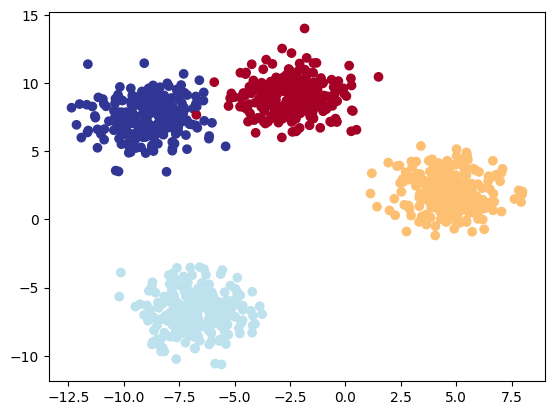

In [77]:
n_samples = 1000

X, y = make_blobs(n_samples,
                  centers=4,
                  cluster_std=1.3,
                  random_state=42)

plt.scatter(
    X[:,0],
    X[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)
plt.savefig("dataset.png")
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
   
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) 

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [78]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class BlobsModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        self.layer_2 = nn.Linear(in_features=hidden_units, out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_2(self.relu(self.layer_1(x)))

blobs_model = BlobsModel(input_features=2,
                        output_features=4).to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(blobs_model.parameters(), lr=0.1)

In [80]:
torch.manual_seed(23)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    blobs_model.train()
    
    y_logits = blobs_model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blobs_model.eval()
    with torch.inference_mode():

        test_logits = blobs_model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        loss_list.append(test_loss)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 100 | Loss: 0.30075, Acc: 81.25% | Test Loss: 0.30762, Test Acc: 83.50%
Epoch: 200 | Loss: 0.16904, Acc: 98.25% | Test Loss: 0.16107, Test Acc: 99.00%
Epoch: 300 | Loss: 0.06088, Acc: 99.88% | Test Loss: 0.05541, Test Acc: 100.00%
Epoch: 400 | Loss: 0.02375, Acc: 99.88% | Test Loss: 0.01926, Test Acc: 100.00%
Epoch: 500 | Loss: 0.01595, Acc: 99.75% | Test Loss: 0.01107, Test Acc: 100.00%
Epoch: 600 | Loss: 0.01333, Acc: 99.75% | Test Loss: 0.00809, Test Acc: 100.00%
Epoch: 700 | Loss: 0.01212, Acc: 99.75% | Test Loss: 0.00660, Test Acc: 100.00%
Epoch: 800 | Loss: 0.01144, Acc: 99.75% | Test Loss: 0.00571, Test Acc: 100.00%
Epoch: 900 | Loss: 0.01101, Acc: 99.75% | Test Loss: 0.00512, Test Acc: 100.00%
Epoch: 1000 | Loss: 0.01072, Acc: 99.75% | Test Loss: 0.00471, Test Acc: 100.00%


In [81]:
blobs_model.eval()
with torch.inference_mode():
    y_logits = blobs_model(X_test)

y_prob = torch.softmax(y_logits, dim=1)
y_pred = y_prob.argmax(dim=1)
y_pred, accuracy_fn(y_test, y_pred)

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
         1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
         2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
         2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
         2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
         1, 3, 2, 0, 3, 1, 2, 1]),
 100.0)

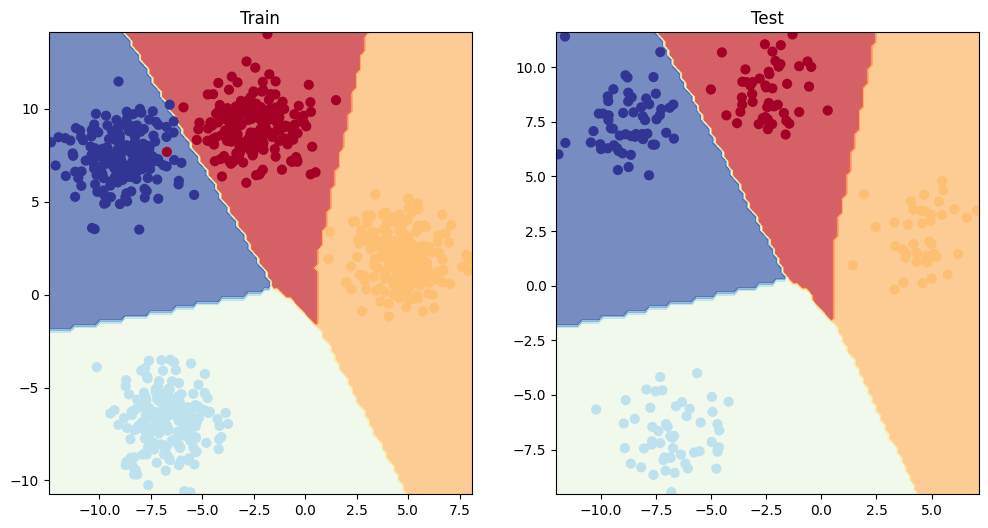

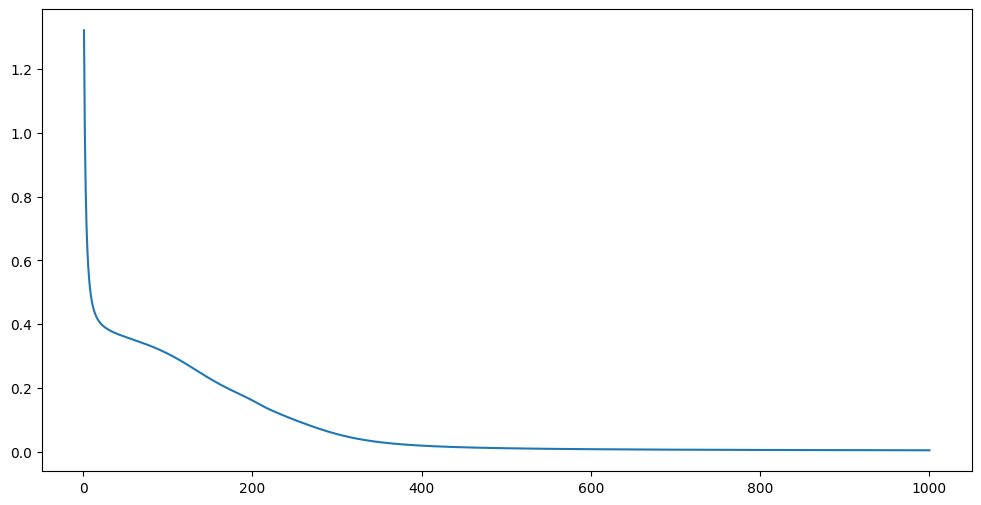

In [84]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(blobs_model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(blobs_model, X_test, y_test)
plt.savefig("first.png")
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(1, epochs+1)], loss_list)
plt.savefig("first_loss.png")

# Результати першого експеременту

Перша спроба відрізняється від данного коду наступним:
- Шум 1.3, а не 1.5
- Кількість епох 1000, а не 100
- Два нейроних слоя, а не три

Маючи такі зміни зі старту, наша модель вже видає 100% точночті на тестових даних. 
Однак, 1000 епох, можливо, забагато. 

В ході експеременту, бачимо, що після 400 епох точність не змінюється, а похибка, хоча і зменшується, проте, у відносно невеликих значеннях. 

**Переходимо до другого експеременту**

Змінюємо кількість епох на 400, та працюємо лише з одним нейроним слоєм

Epoch: 10 | Loss: 0.81974, Acc: 56.50% | Test Loss: 0.72622, Test Acc: 64.00%
Epoch: 20 | Loss: 0.78069, Acc: 62.62% | Test Loss: 0.69166, Test Acc: 71.50%
Epoch: 30 | Loss: 0.76661, Acc: 64.50% | Test Loss: 0.67839, Test Acc: 72.00%
Epoch: 40 | Loss: 0.75845, Acc: 65.50% | Test Loss: 0.67053, Test Acc: 75.00%
Epoch: 50 | Loss: 0.75296, Acc: 66.25% | Test Loss: 0.66544, Test Acc: 75.50%
Epoch: 60 | Loss: 0.74880, Acc: 67.00% | Test Loss: 0.66139, Test Acc: 76.00%
Epoch: 70 | Loss: 0.74566, Acc: 67.75% | Test Loss: 0.65799, Test Acc: 76.00%
Epoch: 80 | Loss: 0.74321, Acc: 68.25% | Test Loss: 0.65531, Test Acc: 76.00%
Epoch: 90 | Loss: 0.74119, Acc: 68.75% | Test Loss: 0.65328, Test Acc: 76.00%
Epoch: 100 | Loss: 0.73958, Acc: 69.00% | Test Loss: 0.65140, Test Acc: 76.50%
Epoch: 110 | Loss: 0.73822, Acc: 69.38% | Test Loss: 0.64990, Test Acc: 76.50%
Epoch: 120 | Loss: 0.73705, Acc: 69.62% | Test Loss: 0.64855, Test Acc: 76.50%
Epoch: 130 | Loss: 0.73604, Acc: 69.88% | Test Loss: 0.64748,

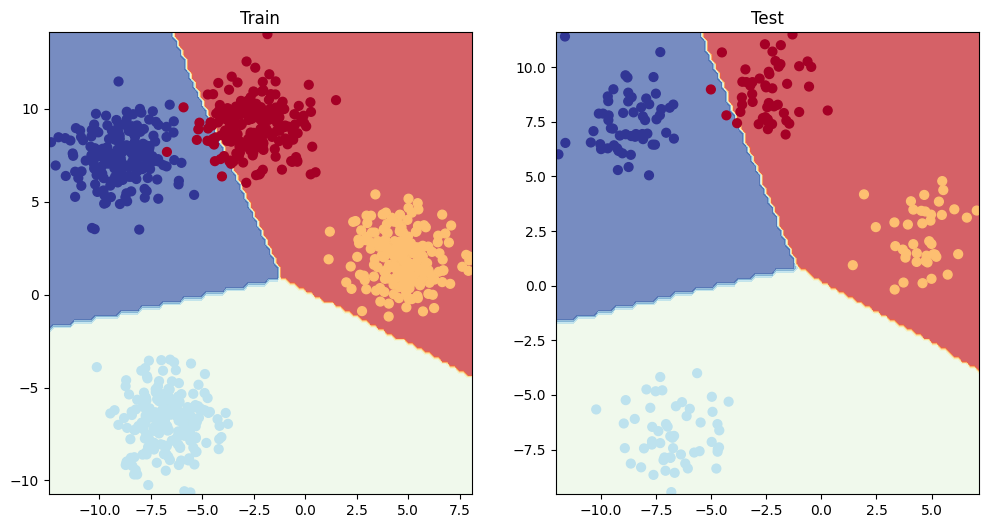

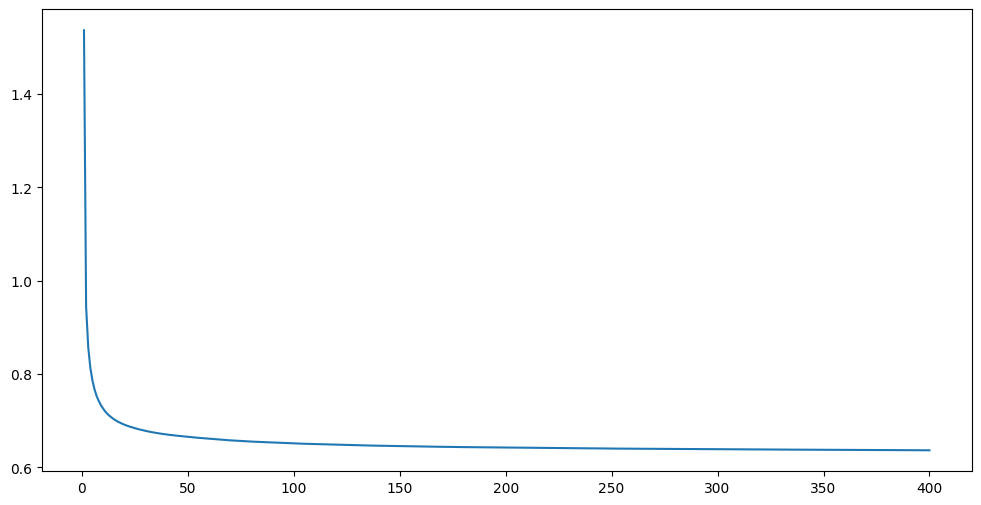

In [87]:
class BlobsModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=output_features)
        # self.layer_2 = nn.Linear(in_features=hidden_units, out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.layer_1(x))

blobs_model = BlobsModel(input_features=2,
                        output_features=4).to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(blobs_model.parameters(), lr=0.1)

torch.manual_seed(23)
epochs = 400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    blobs_model.train()
    
    y_logits = blobs_model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blobs_model.eval()
    with torch.inference_mode():

        test_logits = blobs_model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        loss_list.append(test_loss)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(blobs_model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(blobs_model, X_test, y_test)
plt.savefig("second.png")
plt.figure(figsize=(12,6))
plt.plot([i for i in range(1, epochs+1)], loss_list)
plt.savefig("second_loss.png")

# Результат другого експеременту

Як бачимо, за таких умов модель все ще працює, але далеко не точно.

З одним нейроним слоєм, модель дуже повільно навчається.

Робимо висновок з двох тестів та початкового коду, що оптимально мати два нейроних слоя для цієї задачі.

**Третій експеремент**

Повертаємо другий слой.

Змінюємо параметри вагів.

Змінюємо ReLU на Softplus

Epoch: 10 | Loss: 0.58778, Acc: 78.88% | Test Loss: 0.53373, Test Acc: 83.00%
Epoch: 20 | Loss: 0.35630, Acc: 90.00% | Test Loss: 0.34863, Test Acc: 96.00%
Epoch: 30 | Loss: 0.21727, Acc: 99.62% | Test Loss: 0.21063, Test Acc: 100.00%
Epoch: 40 | Loss: 0.11669, Acc: 99.75% | Test Loss: 0.11370, Test Acc: 100.00%
Epoch: 50 | Loss: 0.07582, Acc: 99.62% | Test Loss: 0.07348, Test Acc: 100.00%
Epoch: 60 | Loss: 0.05683, Acc: 99.75% | Test Loss: 0.05428, Test Acc: 100.00%
Epoch: 70 | Loss: 0.04614, Acc: 99.75% | Test Loss: 0.04331, Test Acc: 100.00%
Epoch: 80 | Loss: 0.03931, Acc: 99.75% | Test Loss: 0.03623, Test Acc: 100.00%
Epoch: 90 | Loss: 0.03458, Acc: 99.75% | Test Loss: 0.03129, Test Acc: 100.00%
Epoch: 100 | Loss: 0.03112, Acc: 99.75% | Test Loss: 0.02765, Test Acc: 100.00%
Epoch: 110 | Loss: 0.02849, Acc: 99.75% | Test Loss: 0.02485, Test Acc: 100.00%
Epoch: 120 | Loss: 0.02642, Acc: 99.75% | Test Loss: 0.02264, Test Acc: 100.00%
Epoch: 130 | Loss: 0.02475, Acc: 99.75% | Test Loss

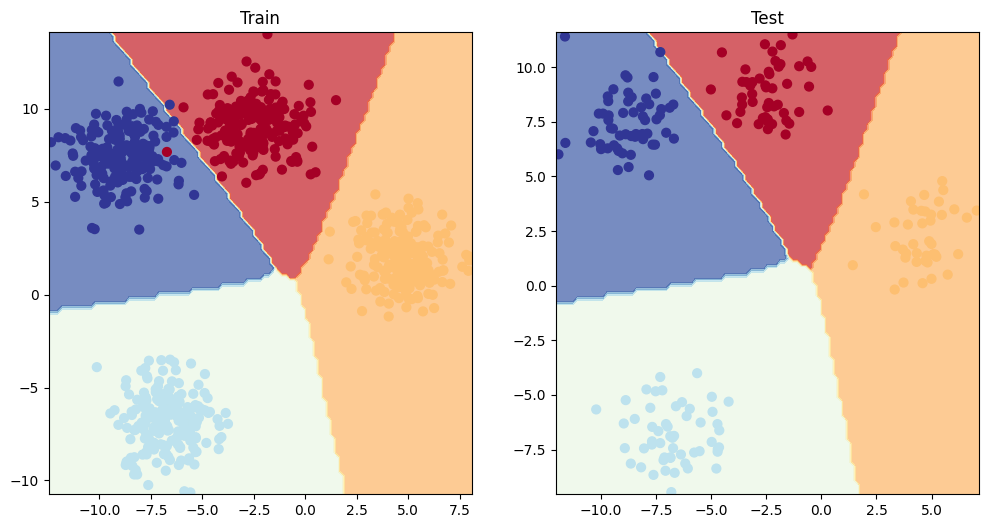

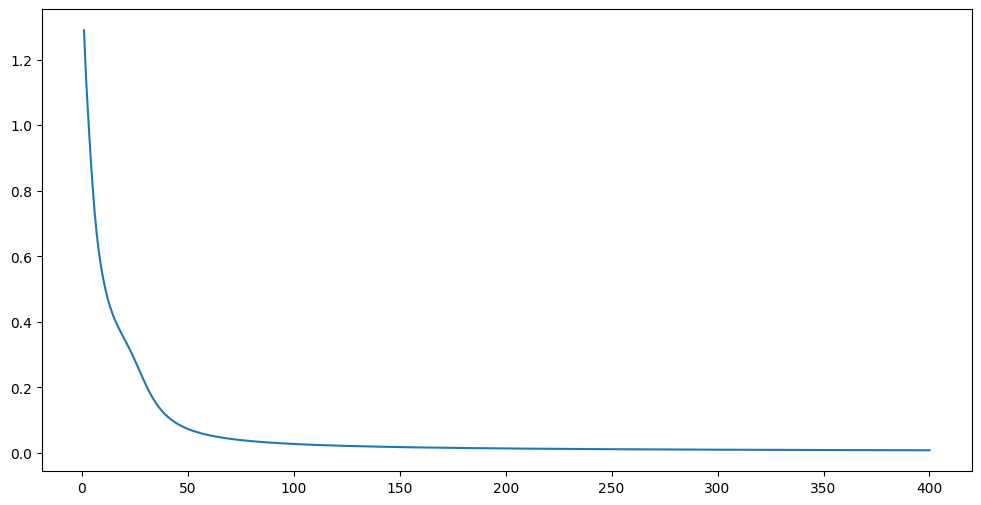

In [89]:
class BlobsModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=4):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        self.layer_2 = nn.Linear(in_features=hidden_units, out_features=output_features)
        self.softplus = nn.Softplus()

    def forward(self, x):
        return self.layer_2(self.softplus(self.layer_1(x)))

blobs_model = BlobsModel(input_features=2,
                        output_features=4).to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(blobs_model.parameters(), lr=0.1)

torch.manual_seed(23)
epochs = 400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    blobs_model.train()
    
    y_logits = blobs_model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blobs_model.eval()
    with torch.inference_mode():

        test_logits = blobs_model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        loss_list.append(test_loss)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(blobs_model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(blobs_model, X_test, y_test)
plt.savefig("third.png")
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(1, epochs+1)], loss_list)
plt.savefig("third_loss.png")

# Висновки

На останньому експеременті ми досягли наших найкращих результатів вже на 40 епосі.

На 400 епосі, наша похибка була майже вдвічі меншою ніж на першому експеременті.

Зважаючи, що метою експерементів є досягнення 100%, наші оптимальні данні наступні:

- Два нейроних слої з Softplus 
- 4 hidden_units
- 30 епох (момент настання 100% точності)

Якщо брати до уваги також і похибку, то вважаю, що параментри маються бути наступні:

- Два нейроних слої з Softplus
- 4 hidden_units
- 40 епох (після цього моменту, похибка змінюється вже в незначній мірі)